# Introduction

The real estate market is a fasinating market to study and in this project we are trying to predict house prices based on data in a local area. The goal of this study is to develop a predictive model using supervised machine learning techniques to predict house prices in a local area based on several predictors.

## Objective

The objective of this project is to accuractely predict house prices for buyers and sellers given housing data. The project will compare Linear Regression and Random Forest models in a preliminary run. Then the model with better initial results will be fine tuned to give the best prediction. 

The houseing data for this project can be found here: <https://www.kaggle.com/competitions/home-data-for-ml-course/data>. 

DanB. Housing Prices Competition for Kaggle Learn Users. https://kaggle.com/competitions/home-data-for-ml-course, 2018. Kaggle.

## Libraries
First we need to install all the necessary packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Data Exploration and Preprocessing

## Loading the Data

First we need to load the data set we will be using. The resource we are using gives us training and test datasets. 

In [2]:
# Load the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

## Data Exploration

We now need to explore the training data set. Lets first look at how many entries there are and how many features we have in the dataframe. 

In [3]:
train_df.shape

(1460, 81)

So as you can see the training dataframe has 1460 rows(data entries) and 81 columns(features). 

Now lets take a look at the training dataframe and see what type of values we are getting. Also lets see the feature names(column headers). 

In [4]:
print(train_df.head())
print(train_df.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

From the data info above we have 43 categorical and 38 numerical features. We will condense these features later in this project, because many of these are similar. 

## Data Cleanup

### Deleting Features

Firstly lets delete the 'Id' feature because it provides no value. I also think it would be good to delete some features because some are extremely similar. The features have several cases where we have quality of xyz, but then we have an overall quality/finish value. We want to just look at the overall quality value since it takes into account all the other quality/finish values. We also have values for when different features were built and it would be best to just look at when the overall house was built. So, we will delete features related to built except for house built year. 

In [5]:
train_df.drop(columns=['Id'], inplace=True)
test_df.drop(columns=['Id'], inplace=True)

In [6]:
drop_features = [
    "YearRemodAdd", "BsmtFinSF1", "GarageYrBlt", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual",
    "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "PoolQC", "Fence", "YearRemodAdd"
]

train_df.drop(columns=drop_features, inplace=True)
test_df.drop(columns=drop_features, inplace=True)

### Missing Data

Now we need to see the number of missing/NA values in the training dataframe. 

In [7]:
print(" The number of NA values in the training Dataframe are:",train_df.isna().sum().sum())
print(" The number of NA values in the testing Dataframe are:",test_df.isna().sum().sum())

 The number of NA values in the training Dataframe are: 4109
 The number of NA values in the testing Dataframe are: 4120


So as you can see we have plenty of NA values that we need to handle.

To handle NA values in numerical features we replace the value with the median value for that column. This is better than the mean because some outliers that have small/large values will affect the median less. 

In [8]:
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    if (train_df[col] == 0).sum() > 0:
        train_df[col] = train_df[col].replace(0, np.nan)
        test_df[col] = test_df[col].replace(0, np.nan) 

train_df.fillna(train_df.median(numeric_only=True), inplace=True)
test_df.fillna(test_df.median(numeric_only=True), inplace=True)


For categorical features I filled in the NA values with the mode value for that feature. This seems like the best way to approach this issue rather than just deleting the entry. We might see some biases from using this method, so we should take note of this in our final analysis. 

In [9]:
for col in train_df.select_dtypes(include=['object']).columns:
    mode_value = train_df[col].mode()[0] 
    train_df[col] = train_df[col].fillna(mode_value) 
    test_df[col] = test_df[col].fillna(mode_value)


Now lets check the NA values again

In [10]:
print(" The number of NA values in the training Dataframe are:",train_df.isna().sum().sum())
print(" The number of NA values in the testing Dataframe are:",test_df.isna().sum().sum())

 The number of NA values in the training Dataframe are: 0
 The number of NA values in the testing Dataframe are: 0


All good!

# Exploratory Data Analysis

We now need to start exploring the data and analyzing the features. Let first do this by looking at the distribution of house prices. 


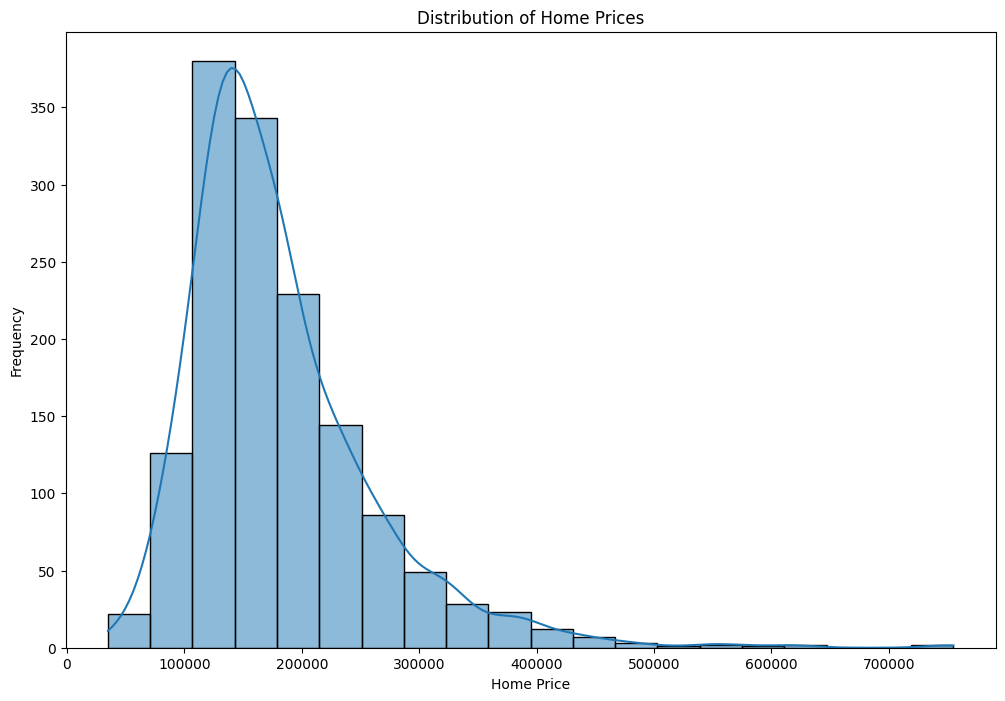

In [11]:
plt.figure(figsize=(12, 8))
sns.histplot(train_df['SalePrice'], bins=20, kde=True)
plt.title("Distribution of Home Prices")
plt.xlabel("Home Price")
plt.ylabel("Frequency")
plt.show()

As you can see the distribution of home prices are roughly in the 100k~300k range. 



## Correlation Matrix

I believe it would be a bit hard to modelo over each feature and it would be better to cut down the feature list to the top 10 features that correlate to home price. 

To find the most correlated features we need to make a correlation matrix. To visually show this we will make a correlation heatmap of all the features. 

For the categorical features we will need to encode them to make them work in correlation analysis. This will give a numerical value to each category("Apple" = 1, "Orange" = 2) so we can correlate data better. 

Below is the code for encoding the data and making the correlation heatmap

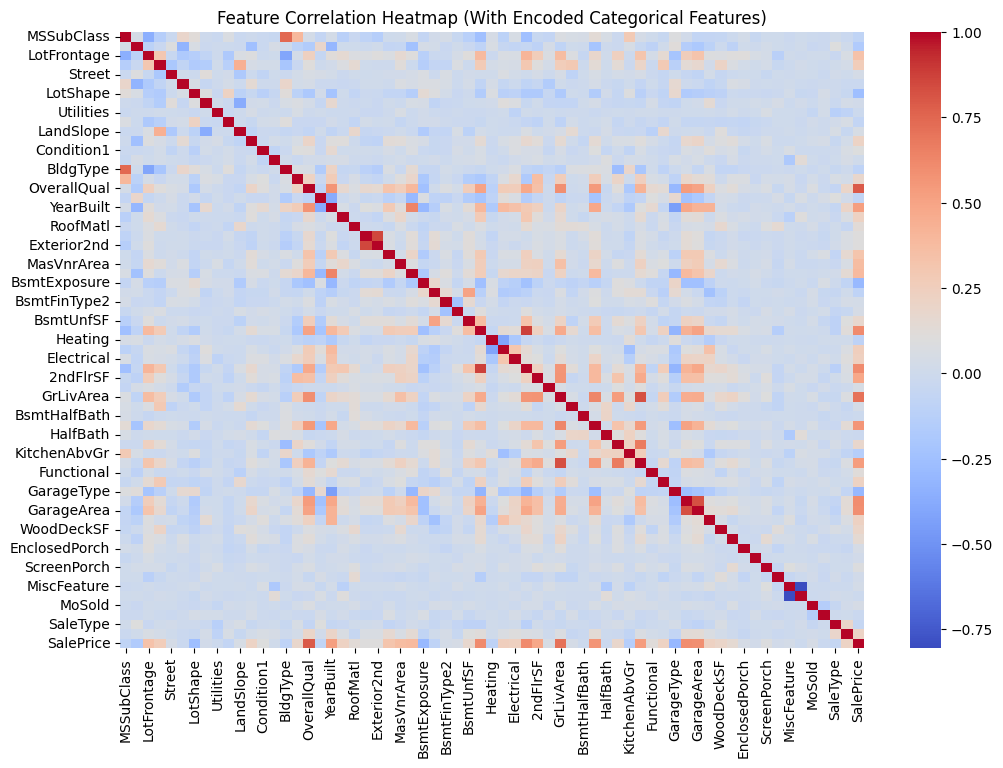

In [12]:
train_df_encoded = train_df.copy()
test_df_encoded = test_df.copy()
label_encoder = LabelEncoder()
for col in train_df_encoded.select_dtypes(include=['object']).columns:
    train_df_encoded[col] = label_encoder.fit_transform(train_df_encoded[col])
    test_df_encoded[col] = label_encoder.fit_transform(test_df_encoded[col])
    
correlation_matrix = train_df_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap (With Encoded Categorical Features)")
plt.show()

This may be hard to see what the top 10 features are for predicting home prices, so below is a list of the top 10. 

In [13]:
correlation = correlation_matrix["SalePrice"].abs().sort_values(ascending=False)
top_features = correlation.index[1:11]
print(top_features)


Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageCars',
       'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', '2ndFlrSF'],
      dtype='object')


### Feature Engineering

So you might see that some of the features seem to be related like GarageCars and GarageArea. So for features like we should combine them so we aren't just getting a bunch of the same features that are highly correlated. 

The features we will combine will be:
* Square footage: OverallSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF + GrLivArea
* Garage: OverallGarage = GarageCars * GarageArea

Below is the code for combining features


In [14]:
train_df_encoded["OverallSF"] = train_df_encoded["TotalBsmtSF"] + train_df_encoded["1stFlrSF"] + train_df_encoded["2ndFlrSF"] + train_df_encoded["GrLivArea"]
test_df_encoded["OverallSF"] = test_df_encoded["TotalBsmtSF"] + test_df_encoded["1stFlrSF"] + test_df_encoded["2ndFlrSF"] + test_df_encoded["GrLivArea"]


train_df_encoded["OverallGarage"] = train_df_encoded["GarageCars"] * train_df_encoded["GarageArea"]
test_df_encoded["OverallGarage"] = test_df_encoded["GarageCars"] * test_df_encoded["GarageArea"]

drop_features = [
    "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", 
    "GarageCars", "GarageArea"
]
train_df_encoded.drop(columns=drop_features, inplace=True)
test_df_encoded.drop(columns=drop_features, inplace=True)

label_encoder = LabelEncoder()
for col in train_df.select_dtypes(include=['object']).columns:
    train_df_encoded[col] = label_encoder.fit_transform(train_df_encoded[col])
    test_df_encoded[col] = label_encoder.transform(test_df_encoded[col])


### New Top 10 features
Below is a list of the new top 10 features that predict home prices. 

In [15]:
correlation_matrix = train_df_encoded.corr()

correlation_with_price = correlation_matrix["SalePrice"].abs().sort_values(ascending=False)

top_features = correlation_with_price[1:11]  # Exclude SalePrice itself

print("Top 10 Features with Correlation:")
print(top_features)

Top 10 Features with Correlation:
OverallQual      0.790982
OverallSF        0.766256
OverallGarage    0.642767
FullBath         0.569616
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
Foundation       0.382479
MasVnrArea       0.372115
LotFrontage      0.334771
MasVnrType       0.322979
Name: SalePrice, dtype: float64


Here are the descriptions for these features in our top 10 list
* OverallQual: Overall material and finish quality of the house.
* OverallSF: Combined total square footage of the basement and above-ground living space.
* OverallGarage: Total garage capacity calculated as GarageCars * GarageArea.
* FullBath: Number of full bathrooms above grade.
* TotRmsAbvGrd: Total number of rooms above ground level.
* YearBuilt: Original construction year of the house.
* Foundation: Type of foundation used in the house
* MasVnrArea: Masonry veneer area in square feet
* LotFrontage: Linear feet of street connected to the property.
* MasVnrType: Type of masonry veneer used on the house 

It would also be good to look at the least correlated features. We will look at the 5 least correlated features. 

In [16]:
correlation_matrix = train_df_encoded.corr()

correlation_with_price = correlation_matrix["SalePrice"].abs().sort_values(ascending=True)

least_correlated_features = correlation_with_price.index[:5]
print("Least Correlated Features:\n", least_correlated_features)

Least Correlated Features:
 Index(['Condition2', 'MiscVal', 'BsmtHalfBath', 'Utilities', 'LandContour'], dtype='object')


The descriptions for these least correlated features are below.

* Condition2: Proximity to main road or railroad
* MiscVal: Value of miscellaneous features in dollars.
* BsmtHalfBath: Basement half bathrooms.
* Utilities: Type of utilities available.
* LandContour: Flatness of the property.

### Correlation Analysis

The results of the correlation analysis make sense. Firstly there seem to be no features that seem extremely related which helps with multicollinearity. Overall quality and overall square footage are the most correlated with home price and I believe this makes sense. The rest of the top 10 list also makes sense, but foundation, MasVnrArea, LotFrontage, and MasVnrType seem to only have a moderate correlation. We will delete the moderately correlated features for our analysis. The least 5 correlated features also makes sense. They seem very obscure and not very impactful compared to square footage or quality of the house. Overall I belive the results from the correlation matrix make sense. 

## Data Visualization

##### Now with these 6 most predicictable features we want to see the how each of them are correlated with the price visually. I decided that scatter plots and bar plots would show the correlations the best.  


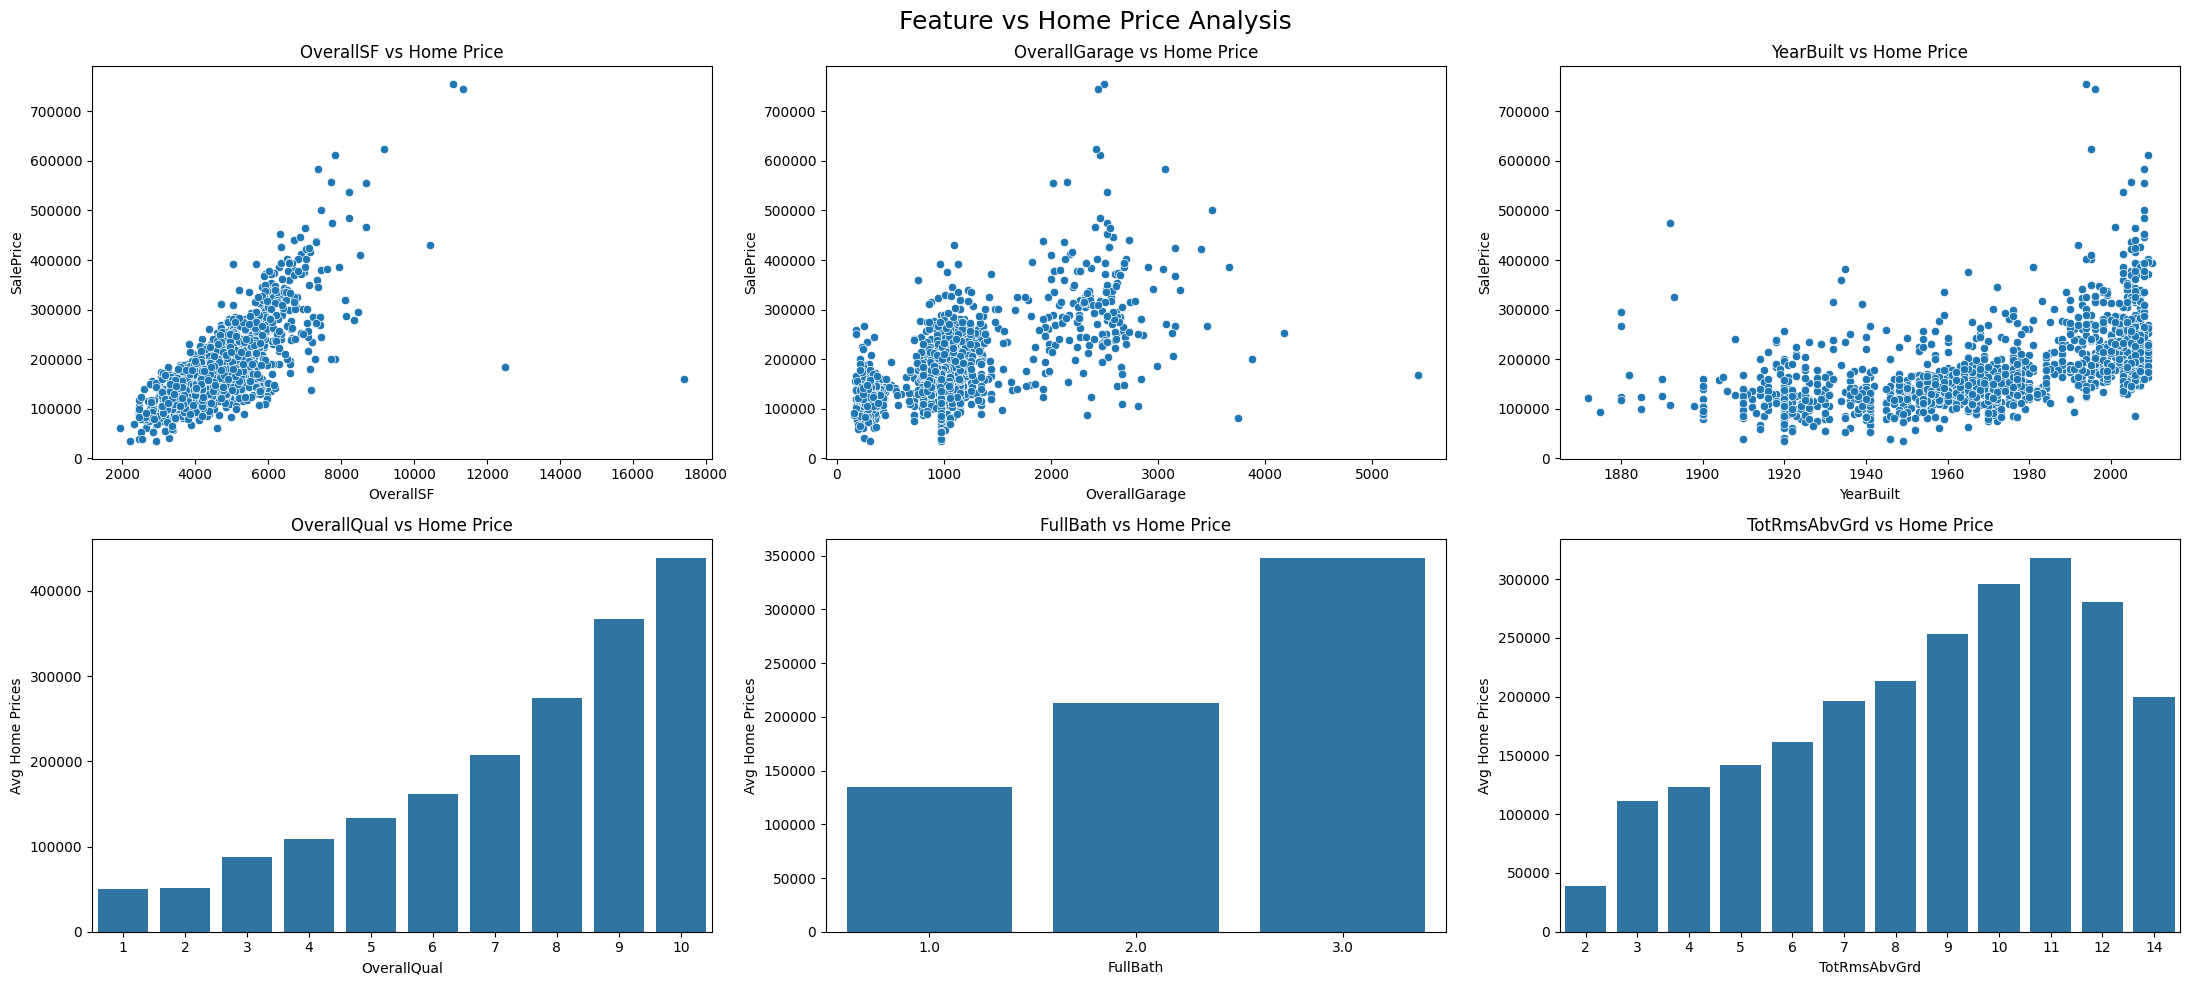

In [17]:
top_features = ['OverallQual', 'OverallSF', 'OverallGarage', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']

fig, axes = plt.subplots(2, 3, figsize=(22, 10))
fig.suptitle("Feature vs Home Price Analysis", fontsize=18)

numeric_features = ['OverallSF', 'OverallGarage', 'YearBuilt']
for i, feature in enumerate(numeric_features):
    sns.scatterplot(x=train_df_encoded[feature], y=train_df_encoded["SalePrice"], ax=axes[0, i])
    axes[0, i].set_title(f"{feature} vs Home Price")
    axes[0, i].set_xlabel(feature)
    axes[0, i].set_ylabel("SalePrice")

categorical_features = ['OverallQual', 'FullBath', 'TotRmsAbvGrd']
for i, feature in enumerate(categorical_features):
    sns.barplot(x=train_df_encoded[feature], y=train_df_encoded["SalePrice"], ax=axes[1, i], errorbar=None)
    axes[1, i].set_title(f"{feature} vs Home Price")
    axes[1, i].set_xlabel(feature)
    axes[1, i].set_ylabel("Avg Home Prices")

plt.tight_layout()
plt.show()

## Checking the Data

After looking at the data everything looks good on the scatter plots and bar plots. All the scatter plots seem to be nearly linear. There are a couple of points that are outside the main trend, but their values don't seem to be horribly off from within reason. So, we will keep those points. 

OverallSF: As the Square footage increases so does the price.
OverallGarage: As the size and number of cars in the garage goes up so does price. It is a bit more random though.
YearBuilt: As the year built goes up, so does the price. Also we have much more data on newer homes. 
OverallQual: As the quality of the house goes up so does price.
FullBath: As you increase the number of full baths in the house the price goes up.
TotRmsAbvGrd: As you increase the number of rooms in the house the price goes up, but after 11 rooms there seems to be a slight drop off. 

# Data Analysis

This is the data analysis section. Firstly we want to to split the data up into training and test data sets. Then we will want to run preliminary test for the two models we will be comparing(Linear Regression and Random Forest). After getting these initial results we will then choose the best model and fine tune it even further to have the best results.   

### Splitting the Data
We will perform a log transformation on the SalePrice(home price) to give the values more of a normal distribution to help with predictions. We will use 30% of the data for testing later. 

In [18]:
X = train_df_encoded[top_features]
y = np.log1p(train_df_encoded["SalePrice"])  
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

### Comparing Models 

Now we will run the the models on the training data and compare the values to actual values. This will tell us which model performed better. To see which model performed better we will be comparing their Coefficients of Determination (R^2) values and their Mean Square Error (MSE). 

The Coefficient of Determination is a good measure for this because it tells you how much of the variance in the target variable is explained by the model. So the R^2 with the highest value gives you the best model fit. 

Mean Squared Error is also another good measurement to use because it gives you the average squared difference between the actual house price and predicted house price. A lower value in this case it better because that means your prediction is closer to the actual value. 

First we need to scale the features in the linear regresion model. We do this because we don't want one feature to dominate the prediction. We only have to do this for linear regression because Random forest isn't affected by feature scales.

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_valid_scaled)

mse_linear = mean_squared_error(y_valid, y_pred_linear)
r2_linear = r2_score(y_valid, y_pred_linear)


rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_valid)

mse_rf = mean_squared_error(y_valid, y_pred_rf)
r2_rf = r2_score(y_valid, y_pred_rf)

results_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MSE": [mse_linear, mse_rf],
    "R2 Score": [r2_linear, r2_rf]
})

print(results_df)


               Model       MSE  R2 Score
0  Linear Regression  0.037838  0.755111
1      Random Forest  0.027580  0.821501


## Preliminary Results

As you can see from the preliminary results Linear Regression got a R^2 value of 0.755111 and MSE of 0.037838. Random Forest got a R^2 value of 0.823621 and MSE of 0.027252. 

With these results we can see that Random Forest provides us a better output because it has a higher R^2 value and a lower MSE value. So we will now further refine the Random Forest model to give us a better value. 

## Optimization

We want to optimize our Random Forest Model. We can do this by optimizing its hyperparameters. Below are the hyper parameters we will optimize:

Hyperparemeters for Random Forest:
* n_estimators: Number of trees in the forest
* max_features: Limits the number of features to consider when splitting
* max_depth: Controls aximum depth of each tree
* min_samples_split: Minimum number of samples needed to split a node
* min_samples_leaf: The minimum number of samples required to be at a leaf node
    

To optimize our model we will be using the grid search method. This method tries all possible combinations of hyperparameters. This will be taxing on processing power and these blocks of code may take a little longer than normal. 

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Optimized Random Forest MSE: 0.025625133678370396
Optimized Random Forest R² Score: 0.8341515067900015


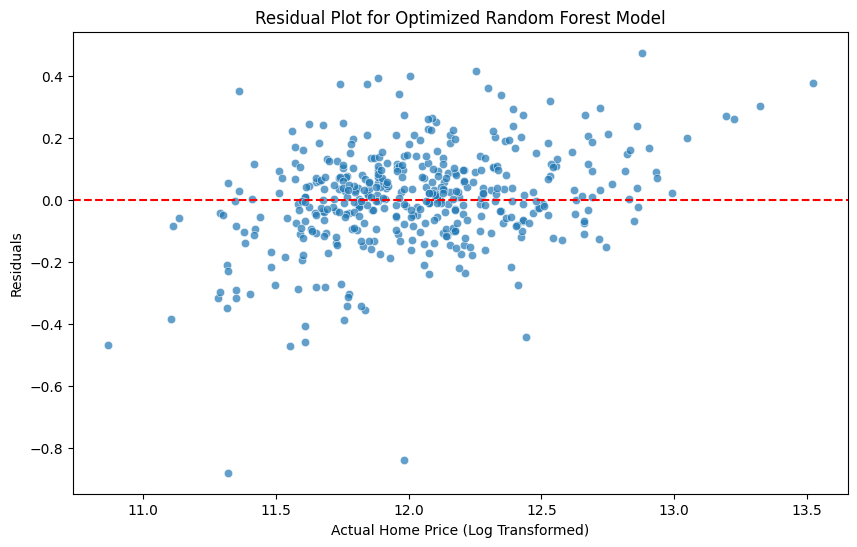

In [20]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    'n_estimators': [100, 200, 500],  
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2']  
}

rf_model = RandomForestRegressor(random_state=0)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

y_pred_rf_optimized = best_rf_model.predict(X_valid)
mse_rf_optimized = mean_squared_error(y_valid, y_pred_rf_optimized)
r2_rf_optimized = r2_score(y_valid, y_pred_rf_optimized)

print("Best Parameters:", grid_search.best_params_)
print("Optimized Random Forest MSE:", mse_rf_optimized)
print("Optimized Random Forest R² Score:", r2_rf_optimized)

residuals = y_valid - y_pred_rf_optimized


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')  
plt.xlabel("Actual Home Price (Log Transformed)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Optimized Random Forest Model")
plt.show()

## Result Analysis

After doing a preliminary test we between linear regression and random forest we got a better R^2 value and MSE value on the random forest model. So, we then decided to further optimize the random forest model by a gridsearch, which searches through all the possible hyperparameter combinations and chooses the best model. After using GridSearchCV the model achieved a R^2 score of 0.8313 wich is slightly better than the random forest model that isn't optmizied. The MSE for the optimized model was also 0.02605 which is also slightly better than the random forest model that is not optimized. 

To check the models reliability we also analyzed the residuals. We did this with a residual plot which showed that most predictions were close to the actual values with the residuals being evenly distributed around the zero line. This means that the model is not biased. 

The best parameters for this model were:
* max_depth: 20
* Max_features: sqrt
* min_samples_leaf: 2
* min_samples_split: 5
* n_estimators: 500

Overall the data looks good and makes sense. 


# Conclusion

The goal of this project was to predict housing prices with different machine learning techniques on a housing prices dataset. We compared linear regression and random forest regression to identify the best model to use for predicting house prices. After deciding on random forest regression we then further optimized the model to give a better result.

We first began by exploring the dataset. We deleted related features and we handled missing values. We then used feature engineering to combine related features. To improve the model efficiency we used a correlation matrix to find the features that relate to house prices the most. After this we got a list of the most predictive features and used these features in our models. 

To run our models we split the training dataset into 70% training data and 30% testing data. We then performed preliminary test to figure out if linear regression or random forest and the results showed that random forest was much better. We then further optimized our random forest solution by optimizing the hyperparameters. After doing this we then checked if there was any issues with the residual plot and nothing was alarming. 

In the future it may be good to try additional models that could futher optimize the solution. 


### Overall

Overall, this project was a sucess and we were able to reliably predict home prices using the random forest regression model. 